In [2]:
import os

import autogen
from autogen import UserProxyAgent
from autogen.agentchat.contrib.huggingface_agent import HuggingFaceAgent

config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={"model": "gpt-4"},
)

assistant = HuggingFaceAgent(
    name="multimodal_assistant",
    llm_config={"config_list": config_list},
    hf_task_list=["TEXT_TO_IMAGE"],
    hf_config={"api_key": os.environ.get("HUGGINGFACE_API_KEY")},
)

user_proxy = UserProxyAgent(
    name="user_proxy",
    human_input_mode="NEVER",
    code_execution_config=False,
    default_auto_reply="",
    is_termination_msg=lambda x: True,
)

user_proxy (to multimodal_assistant):

Create an image with black background, a happy robot is showing a sign with 'I Love AutoGen'.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION text-to-image...
multimodal_assistant (to user_proxy):

I generated an image with the prompt: A happy robot on a black background holding a sign that reads 'I Love AutoGen'.<image>

--------------------------------------------------------------------------------


ChatResult(chat_id=None, chat_history=[{'content': "Create an image with black background, a happy robot is showing a sign with 'I Love AutoGen'.", 'role': 'assistant'}, {'content': [{'type': 'text', 'text': "I generated an image with the prompt: A happy robot on a black background holding a sign that reads 'I Love AutoGen'."}, {'type': 'image_url', 'image_url': {'url': ''}}], 'role': 'user'}], summary="I generated an image with the prompt: A happy robot on a black background holding a sign that reads 'I Love AutoGen'.", cost={'usage_including_cached_inference': {'total_cost': 0}, 'usage_excluding_cached_inference': {'total_cost': 0}}, human_input=[])
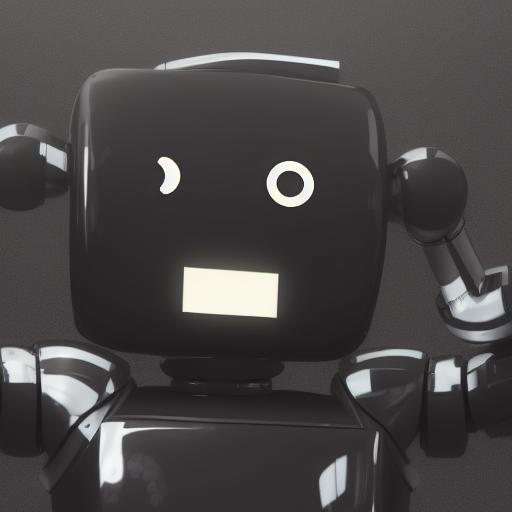

In [3]:
user_proxy.initiate_chat(
    assistant, message="Create an image with black background, a happy robot is showing a sign with 'I Love AutoGen'."
)

In [4]:
import re

import PIL

from autogen.agentchat.agent import Agent
from autogen.agentchat.contrib.img_utils import get_pil_image


def extract_img(agent: Agent) -> PIL.Image:
    """
    Extracts an image from the last message of an agent and converts it to a PIL image.

    This function searches the last message sent by the given agent for an image tag,
    extracts the image data, and then converts this data into a PIL (Python Imaging Library) image object.

    Parameters:
        agent (Agent): An instance of an agent from which the last message will be retrieved.

    Returns:
        PIL.Image: A PIL image object created from the extracted image data.

    Note:
    - The function assumes that the last message contains an <img> tag with image data.
    - The image data is extracted using a regular expression that searches for <img> tags.
    - It's important that the agent's last message contains properly formatted image data for successful extraction.
    - The `_to_pil` function is used to convert the extracted image data into a PIL image.
    - If no <img> tag is found, or if the image data is not correctly formatted, the function may raise an error.
    """
    last_message = agent.last_message()["content"]

    if isinstance(last_message, str):
        img_data = re.findall("<img (.*)>", last_message)[0]
    elif isinstance(last_message, list):
        # The GPT-4V format, where the content is an array of data
        for item in last_message:
            if "image_url" in item:
                img_data = item["image_url"]["url"]
                break

    pil_img = get_pil_image(img_data)
    return pil_img

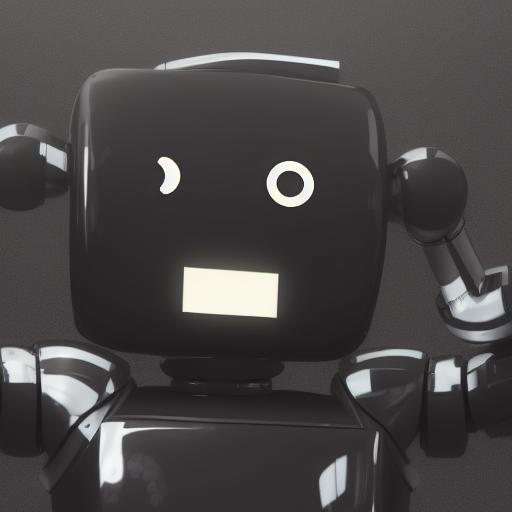

In [5]:
extract_img(assistant)